In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator

from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

import os
import wandb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 27.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
df =  pd.read_csv("/content/captions.txt")
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
distinct_images = df['image'].unique()
sampled_images = np.random.choice(distinct_images, size=200, replace=False)

df = df[df['image'].isin(sampled_images)]

df.shape

(1000, 2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


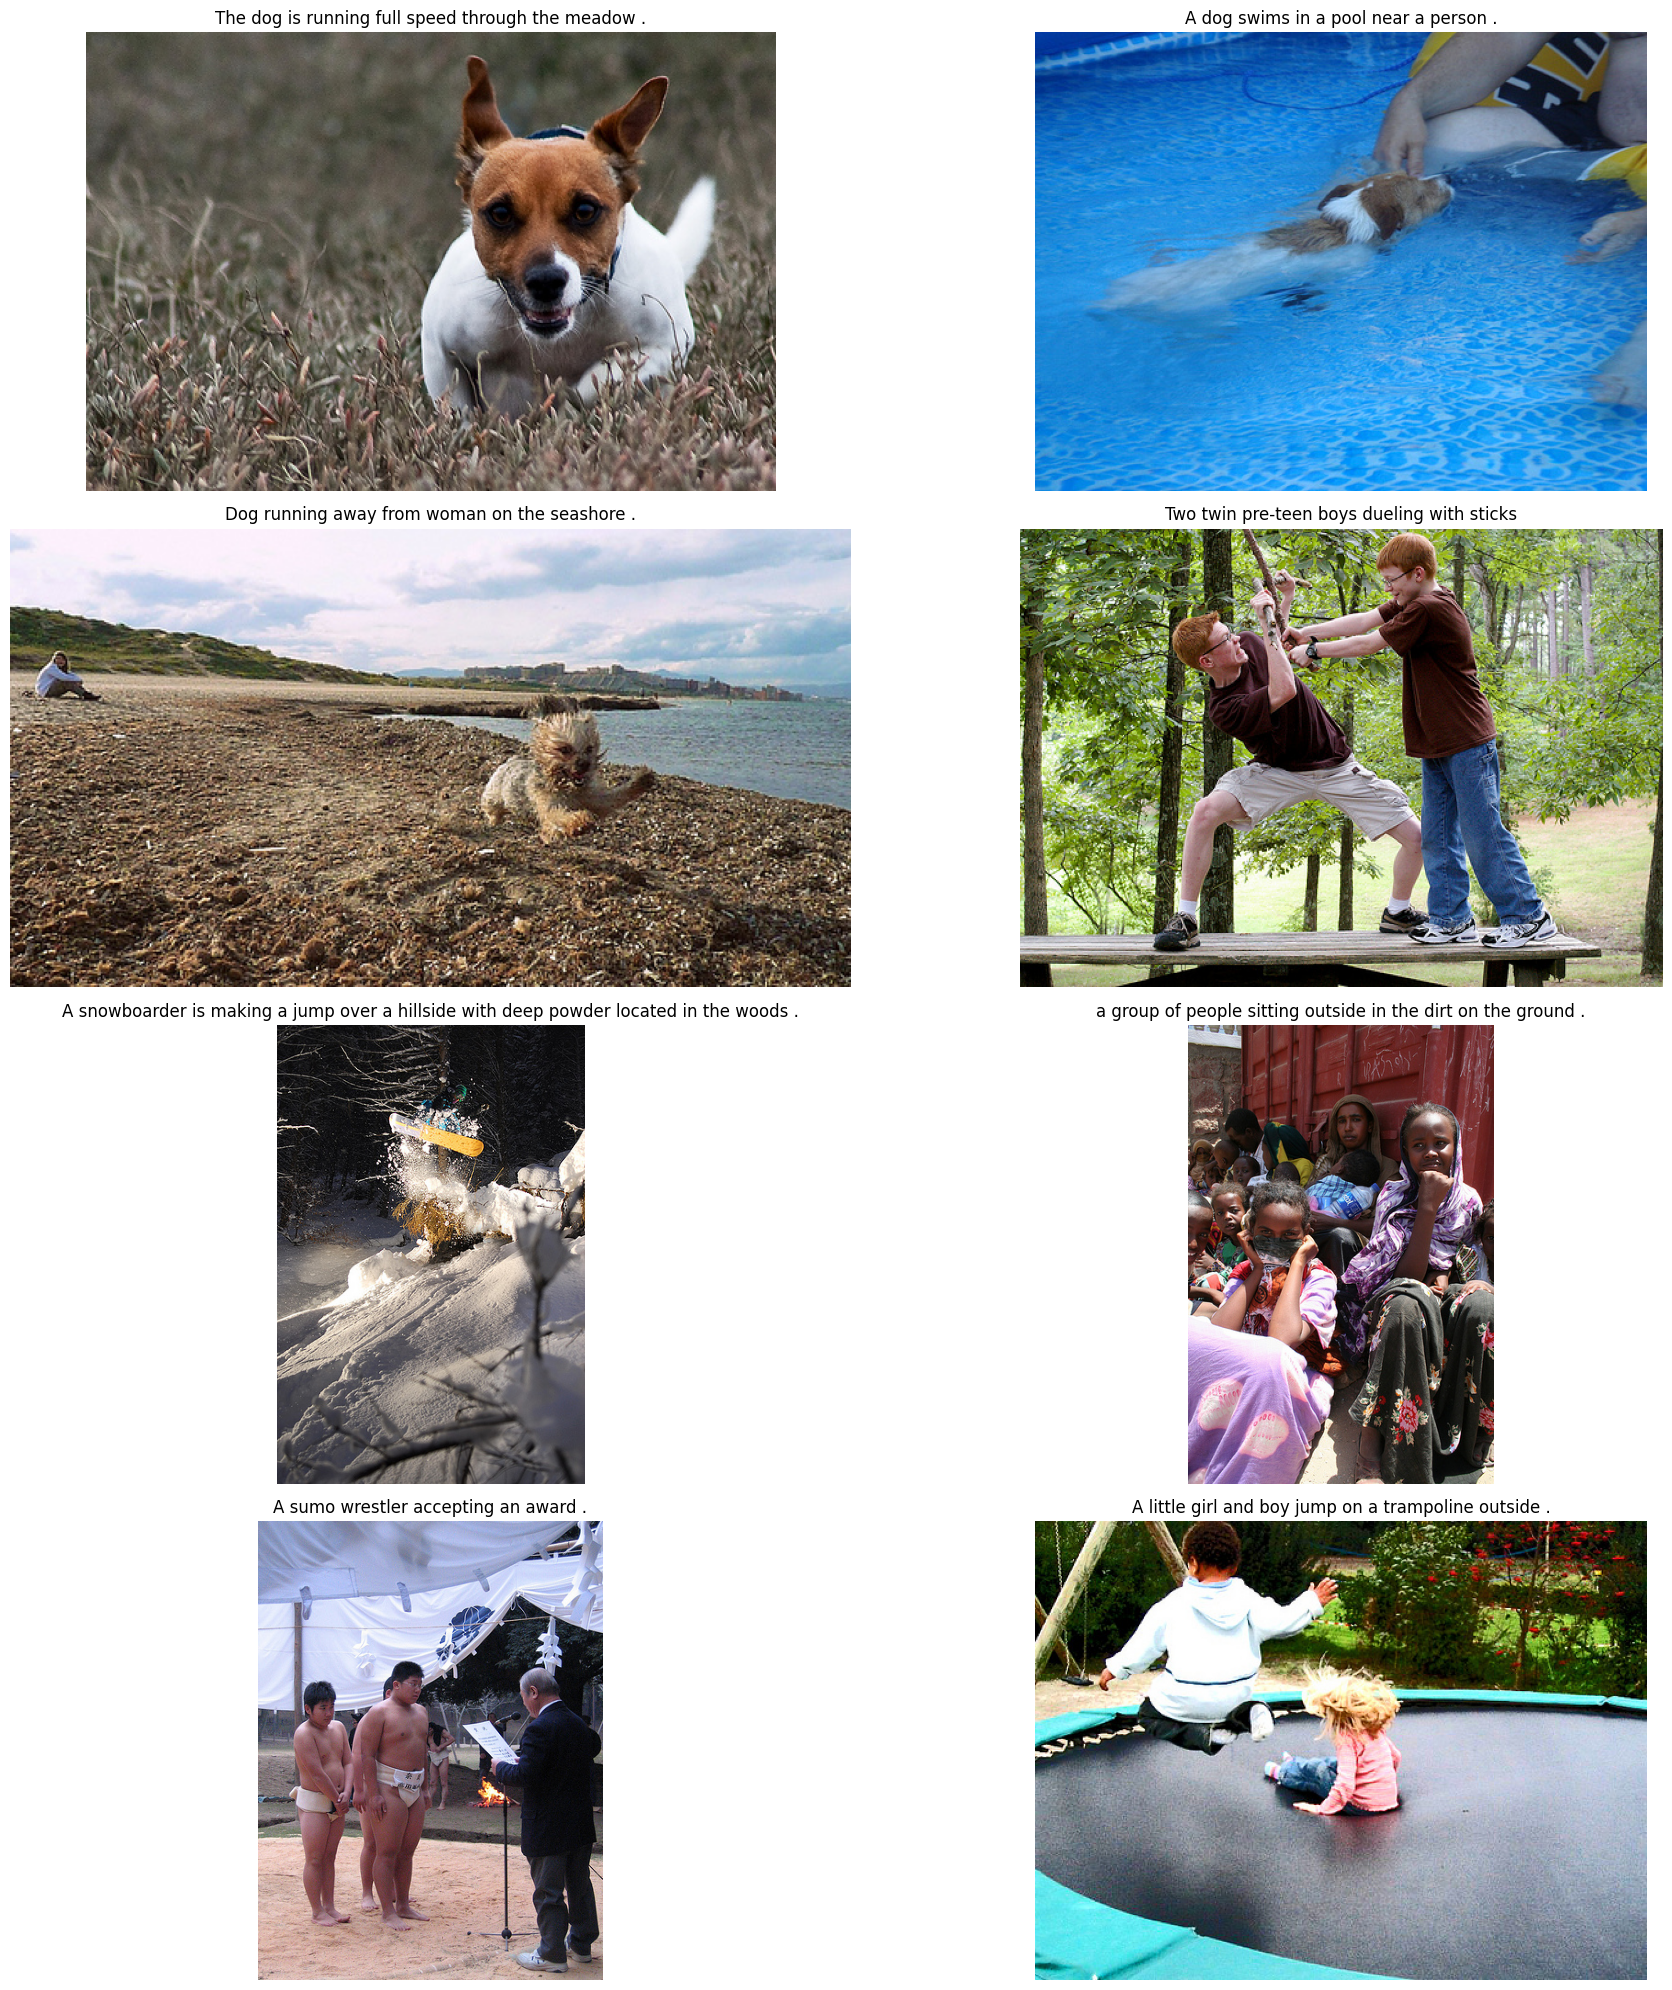

In [ ]:
sampled_df = df.sample(n=8)
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    full_image_path = os.path.join("/content/drive/MyDrive/Images", image_path) # Join directory and filename
    image = Image.open(full_image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)


plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
null_counts = df.isnull().sum()
print("Null values in each column:\n", null_counts)

Null values in each column:
 image      0
caption    0
dtype: int64


In [ ]:
df.dropna(subset=['caption'], inplace=True)

In [ ]:
duplicate_counts = df.duplicated().sum()
print("Total number of duplicate rows:", duplicate_counts)

Total number of duplicate rows: 0


In [ ]:
df.drop_duplicates(subset=['caption'], inplace=True)

In [ ]:
df = df[df['caption'].str.split().str.len() <= 20]

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('WinKawaks/vit-small-patch16-224')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        )
   ]
)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image_path = self.df.image.iloc[idx]
        full_image_path = os.path.join("/content/drive/MyDrive/Images", image_path)
        img = Image.open(full_image_path).convert("RGB")
        if self.transform is not None:
            img= self.transform(img)
        img = (img - img.min()) / (img.max() - img.min())
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values

        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids

        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding


In [ ]:
train_df, test_df = train_test_split(df,test_size=0.2)
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(test_df))

777 195


In [ ]:
train_dataset = ImageDataset(train_df, root_dir = "Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
test_dataset = ImageDataset(test_df , root_dir = "Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

In [ ]:
ENCODER = "WinKawaks/vit-small-patch16-224"
DECODER = "gpt2-medium"

# The Vision Encoder Decoder Model Initialization
ViT_model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(ENCODER, DECODER)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# cls_token represents the class of the input
ViT_model.config.decoder_start_token_id = tokenizer.cls_token_id

# pad_token is used to make arrays of tokens the same size
ViT_model.config.pad_token_id = tokenizer.pad_token_id

# Vocabulary size of the GPT-2 model (default to 50257)
ViT_model.config.vocab_size = ViT_model.config.decoder.vocab_size

# A token to sepearte two different sentences in the same input
ViT_model.config.eos_token_id = tokenizer.sep_token_id
# A token to indicate start of a sequence or sentence
ViT_model.config.decoder_start_token_id = tokenizer.bos_token_id

# setting maximum length of the sequence to be generated
ViT_model.config.max_length = 13

# early_stopping to stop the generation
# when certain conditions are met
ViT_model.config.early_stopping = True

# no_repeat_ngram_size used to prevent repetition
ViT_model.config.no_repeat_ngram_size = 2

# length_penalty implements exponential penalty to the length.
# 1.0 means no penalty.
ViT_model.config.length_penalty = 1.2

# set num_beams to define number of beams for beam search.
# 1 means no beam search.
ViT_model.config.num_beams = 6

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    run_name='vit_model_my_run',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    predict_with_generate=True,
    evaluation_strategy="epoch", # Evaluation is done at the end of each epoch.
    do_train=True, # Whether to run training or not
    do_eval=True, # Whether to run evaluation on the validation set or not
    logging_steps=1024, # Number of update steps between two logs
    save_steps=2048, # Number of updates steps before two checkpoint saves
    warmup_steps=1024, # Number of steps used for a linear warmup from 0 to learning_rate
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = 4, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    gradient_accumulation_steps=2,
    save_total_limit=1,# limit the total amount of checkpoints
)

In [ ]:
import nltk
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    pred_bleu = [line.split() for line in pred_str]
    label_bleu = []

    for item in label_str:
        label_bleu.append([])
        label_bleu[-1].append(item.split())

    # Calculate BLEU score
    bleu_output = nltk.translate.bleu_score.corpus_bleu(label_bleu, pred_bleu)
    return {
        "bleu_score": round(bleu_output, 4)
    }

In [ ]:
#  initialize trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=ViT_model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    eval_dataset=test_dataset,
    data_collator=default_data_collator
)

In [ ]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-3435b262f1ae>", line 1, in <cell line: 1>
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2123, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2534, in _inner_training_loop
    self.optimizer.step()
  File "/usr/local/lib/python3.10/dist-packages/accelerate/optimizer.py", line 171, in step
    self.optimizer.step(closure)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py", line 137, in wrapper
    return func.__get__(opt, opt.__class__)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-pack

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

# Accessing evaluation metrics
eval_results

In [ ]:
for i in range(5):
    det = False
    test = test_df.sample(n=1).values[0]
    test_img, test_caption = test[0],test[1]
    full_image_path = os.path.join("/content/drive/MyDrive/Images", image_path)
    #image = Image.open(full_image_path)
    plt.imshow(Image.open(full_image_path).convert('RGB'))
    img =  Image.open(full_image_path).convert("RGB")
    t = np.random.uniform(0.5,1.5)
    if i > 10:
        det = True
    generated_caption = tokenizer.decode(ViT_model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
    generated_caption = generated_caption.replace("<|endoftext|>", "")
    #gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {generated_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()